# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [36]:
env_info.vector_observations

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.14030886, -1.5       , -0.        ,  0.        ,
        -7.11741829,  5.96076012, -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -7.9574213 , -1.5       ,  0.        ,  0.        ,
         7.11741829,  5.96076012,  0.        ,  0.        ]])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [21]:
# individual network settings for each actor + critic pair
# see networkforall for details

from networkforall import Network
from utilities import hard_update, gumbel_softmax, onehot_from_logits
from torch.optim import Adam
import torch
import numpy as np


# add OU noise for exploration
from OUNoise import OUNoise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

class DDPGAgent:
    def __init__(self, in_actor, hidden_in_actor, hidden_out_actor, out_actor, in_critic, hidden_in_critic, hidden_out_critic, lr_actor=1.0e-2, lr_critic=1.0e-2):
        super(DDPGAgent, self).__init__()

        self.actor = Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True).to(device)
        self.critic = Network(in_critic, hidden_in_critic, hidden_out_critic, 1).to(device)
        self.target_actor = Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True).to(device)
        self.target_critic = Network(in_critic, hidden_in_critic, hidden_out_critic, 1).to(device)

        self.noise = OUNoise(out_actor, scale=1.0 )

        
        # initialize targets same as original networks
        hard_update(self.target_actor, self.actor)
        hard_update(self.target_critic, self.critic)

        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr_critic, weight_decay=1.e-5)


    def act(self, obs, noise=0.0):
        obs = obs.to(device)
        action = self.actor(obs) + noise*self.noise.noise()
        return action

    def target_act(self, obs, noise=0.0):
        obs = obs.to(device)
        action = self.target_actor(obs) + noise*self.noise.noise()
        return action

In [49]:
# main code that contains the neural network setup
# policy + critic updates
# see ddpg.py for other details in the network

from ddpg import DDPGAgent
import torch
from utilities import soft_update, transpose_to_tensor, transpose_list
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'



class MADDPG:
    def __init__(self, discount_factor=0.95, tau=0.02):
        super(MADDPG, self).__init__()

        # critic input = obs_full + actions = 14+2+2+2=20
        # def __init__(self, in_actor, hidden_in_actor, hidden_out_actor, out_actor, in_critic, hidden_in_critic, hidden_out_critic, lr_actor=1.0e-2, lr_critic=1.0e-2):
        #self.maddpg_agent = [DDPGAgent(14, 16, 8, 2, 20, 32, 16), 
        #                     DDPGAgent(14, 16, 8, 2, 20, 32, 16), 
        #                     DDPGAgent(14, 16, 8, 2, 20, 32, 16)]
        num_in_actor = state_size # <-------------------------------------------------
        num_in_critic = state_size + action_size  # <-------------------------------------------------
        num_out_actor = action_size
        self.maddpg_agent = [DDPGAgent(in_actor=num_in_actor, hidden_in_actor=16, hidden_out_actor=8, out_actor=num_out_actor, in_critic=num_in_critic, hidden_in_critic=32, hidden_out_critic=16), 
                             DDPGAgent(in_actor=num_in_actor, hidden_in_actor=16, hidden_out_actor=8, out_actor=num_out_actor, in_critic=num_in_critic, hidden_in_critic=32, hidden_out_critic=16), 
                             DDPGAgent(in_actor=num_in_actor, hidden_in_actor=16, hidden_out_actor=8, out_actor=num_out_actor, in_critic=num_in_critic, hidden_in_critic=32, hidden_out_critic=16)]
        
        self.discount_factor = discount_factor
        self.tau = tau
        self.iter = 0

    def get_actors(self):
        """get actors of all the agents in the MADDPG object"""
        actors = [ddpg_agent.actor for ddpg_agent in self.maddpg_agent]
        return actors

    def get_target_actors(self):
        """get target_actors of all the agents in the MADDPG object"""
        target_actors = [ddpg_agent.target_actor for ddpg_agent in self.maddpg_agent]
        return target_actors

    def act(self, obs_all_agents, noise=0.0):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(obs, noise) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return actions

    def target_act(self, obs_all_agents, noise=0.0):
        """get target network actions from all the agents in the MADDPG object """
        target_actions = [ddpg_agent.target_act(obs, noise) for ddpg_agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return target_actions

    #def update(self, samples, agent_number, logger):
    def update(self, samples, agent_number):
        """update the critics and actors of all the agents """

        # need to transpose each element of the samples
        # to flip obs[parallel_agent][agent_number] to
        # obs[agent_number][parallel_agent]
        obs, obs_full, action, reward, next_obs, next_obs_full, done = map(transpose_to_tensor, samples)

        obs_full = torch.stack(obs_full)
        next_obs_full = torch.stack(next_obs_full)
        
        agent = self.maddpg_agent[agent_number]
        agent.critic_optimizer.zero_grad()

        #critic loss = batch mean of (y- Q(s,a) from target network)^2
        #y = reward of this timestep + discount * Q(st+1,at+1) from target network
        target_actions = self.target_act(next_obs)
        target_actions = torch.cat(target_actions, dim=1)
        
        target_critic_input = torch.cat((next_obs_full.t(),target_actions), dim=1).to(device)
        
        with torch.no_grad():
            q_next = agent.target_critic(target_critic_input)
        
        y = reward[agent_number].view(-1, 1) + self.discount_factor * q_next * (1 - done[agent_number].view(-1, 1))
        action = torch.cat(action, dim=1)
        critic_input = torch.cat((obs_full.t(), action), dim=1).to(device)
        q = agent.critic(critic_input)

        huber_loss = torch.nn.SmoothL1Loss()
        critic_loss = huber_loss(q, y.detach())
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
        agent.critic_optimizer.step()

        #update actor network using policy gradient
        agent.actor_optimizer.zero_grad()
        # make input to agent
        # detach the other agents to save computation
        # saves some time for computing derivative
        q_input = [ self.maddpg_agent[i].actor(ob) if i == agent_number \
                   else self.maddpg_agent[i].actor(ob).detach()
                   for i, ob in enumerate(obs) ]
                
        q_input = torch.cat(q_input, dim=1)
        # combine all the actions and observations for input to critic
        # many of the obs are redundant, and obs[1] contains all useful information already
        q_input2 = torch.cat((obs_full.t(), q_input), dim=1)
        
        # get the policy gradient
        actor_loss = -agent.critic(q_input2).mean()
        actor_loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.actor.parameters(),0.5)
        agent.actor_optimizer.step()

        al = actor_loss.cpu().detach().item()
        cl = critic_loss.cpu().detach().item()
        #logger.add_scalars('agent%i/losses' % agent_number,
        #                   {'critic loss': cl,
        #                    'actor_loss': al},
        #                   self.iter)

    def update_targets(self):
        """soft update targets"""
        self.iter += 1
        for ddpg_agent in self.maddpg_agent:
            soft_update(ddpg_agent.target_actor, ddpg_agent.actor, self.tau)
            soft_update(ddpg_agent.target_critic, ddpg_agent.critic, self.tau)

In [47]:
from utilities import transpose_list, transpose_to_tensor
mylist = np.array([[1,1],[2,2],[3,3]])
a, b = transpose_list(mylist)
a
b
obs_full = transpose_list(states)
obs_full

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [-6.140308856964111, -7.95742130279541],
 [-1.5, -1.5],
 [-0.0, 0.0],
 [0.0, 0.0],
 [-7.11741828918457, 7.11741828918457],
 [5.960760116577148, 5.960760116577148],
 [-0.0, 0.0],
 [0.0, 0.0]]

In [42]:
states

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.14030886, -1.5       , -0.        ,  0.        ,
        -7.11741829,  5.96076012, -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -7.9574213 , -1.5       ,  0.        ,  0.        ,
         7.11741829,  5.96076012,  0.        ,  0.        ]])

In [62]:
# main function that sets up environments
# perform training loop

#import envs
from buffer import ReplayBuffer
#from maddpg import MADDPG
import torch
import numpy as np
#from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor

# keep training awake
#from workspace_utils import keep_awake

# for saving gif
#import imageio

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity


def main(env, brain_name):
    seeding()
    # number of parallel agents
    parallel_envs = 4
    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    number_of_episodes = 1000
    episode_length = 80
    batchsize = 1000
    # how many episodes to save policy and gif
    save_interval = 1000
    t = 0
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999

    # how many episodes before update
    episode_per_update = 2 * parallel_envs

    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    
    os.makedirs(model_dir, exist_ok=True)

    ####
    #torch.set_num_threads(parallel_envs)
    #env = envs.make_parallel_env(parallel_envs)
    ####
    

    # keep 5000 episodes worth of replay
    buffer = ReplayBuffer(int(5000*episode_length))
    
    # initialize policy and critic
    maddpg = MADDPG()
    #logger = SummaryWriter(log_dir=log_path)
    agent0_reward = []
    agent1_reward = []
    #agent2_reward = []

    # training loop
    # show progressbar
    #import progressbar as pb
    #widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
    #          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    #timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

    # use keep_awake to keep workspace from disconnecting
    #for episode in keep_awake(range(0, number_of_episodes, parallel_envs)):
    for episode in range(0, number_of_episodes, parallel_envs):

        #timer.update(episode)


        #reward_this_episode = np.zeros((parallel_envs, 3))
        reward_this_episode = np.zeros((1, 2))
        #all_obs = env.reset() #
        #obs, obs_full = transpose_list(all_obs)
        ####
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        # the MADDPG paper explains that the critic of each individual DDPG agent should "look" at the actions and states of all the agents at training time. 
        # Given that, you have to build an observation_full and an action_full to accomplish that requirement; 
        # they simply concatenate all the observations and actions (respectively) of all the agents and use it as input for the critic).
        obs_full = transpose_list(states)
        ####

        #for calculating rewards for this particular episode - addition of all time steps

        # save info or not
        #save_info = ((episode) % save_interval < parallel_envs or episode==number_of_episodes-parallel_envs)
        frames = []
        tmax = 0
        
        #if save_info:
        #    frames.append(env.render('rgb_array'))

        
        for episode_t in range(episode_length):

            t += parallel_envs
            

            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            #actions = maddpg.act(transpose_to_tensor(obs), noise=noise)
            
            print("states:", obs_full)
            print("transpose_to_tensor(states):", transpose_to_tensor(obs_full))
            actions = maddpg.act(transpose_to_tensor(obs_full), noise=noise)
            noise *= noise_reduction
            
            actions_array = torch.stack(actions).detach().numpy()

            # transpose the list of list
            # flip the first two indices
            # input to step requires the first index to correspond to number of parallel agents
            actions_for_env = np.rollaxis(actions_array,1)
            
            # step forward one frame
            #next_obs, next_obs_full, rewards, dones, info = env.step(actions_for_env)
            ####
            #env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            env_info = env.step(actions_for_env)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
            
            # add data to buffer
            #transition = (obs, obs_full, actions_for_env, rewards, next_obs, next_obs_full, dones)
            next_obs_full = transpose_list(states)
            transition = (states, obs_full, actions_for_env, rewards, next_states, next_obs_full, dones)
            
            buffer.push(transition)
            
            reward_this_episode += rewards

            #obs, obs_full = next_obs, next_obs_full
            
            obs, obs_full = next_states, next_obs_full
            
            # save gif frame
            #if save_info:
            #    frames.append(env.render('rgb_array'))
            #    tmax+=1
        
        # update once after every episode_per_update
        if len(buffer) > batchsize and episode % episode_per_update < parallel_envs:
            #for a_i in range(3):
            for a_i in range(2):
                samples = buffer.sample(batchsize)
                #maddpg.update(samples, a_i, logger)
                maddpg.update(samples, a_i)
            maddpg.update_targets() #soft update the target network towards the actual networks

        
        
        #for i in range(parallel_envs):
        for i in range(1):
            agent0_reward.append(reward_this_episode[i,0])
            agent1_reward.append(reward_this_episode[i,1])
            #agent2_reward.append(reward_this_episode[i,2])

        if episode % 100 == 0 or episode == number_of_episodes-1:
            #avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward), np.mean(agent2_reward)]
            avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward)]
            agent0_reward = []
            agent1_reward = []
            #agent2_reward = []
            #for a_i, avg_rew in enumerate(avg_rewards):
            #    logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)

        #saving model
        save_dict_list =[]
        """"
        if save_info:
            for i in range(3):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}.pt'.format(episode)))
                
            # save gif files
            imageio.mimsave(os.path.join(model_dir, 'episode-{}.gif'.format(episode)), 
                            frames, duration=.04)
        """
        
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

    #env.close()
    #logger.close()
    #timer.finish()

if __name__=='__main__':
    main(env, brain_name)


states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-6.760613918304443, -7.228652477264404], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [7.780412673950195, -7.780412673950195], [5.976456165313721, 5.976456165313721], [-0.0, 0.0], [0.0, 0.0]]
transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -6.7606, -1.5000, -0.0000,  0.0000,  7.7804,  5.9765, -0.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.2287, -1.5000,  0.0000,  0.0000, -7.7804,  5.9765,  0.0000,  0.0000])]
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0,

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722,  7.7804,  4.9170, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  7.7804,  4.4069, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102,  7.7804,  3.7986, 30.0000,  1.3102]), tensor([ -8.0310,  -1.8522, -30.0000,   0.0000,  -7.7804,   4.9170, -30.0000,
          0.0000, -11.0310,  -1.1836, -30.0000,   6.4114,  -7.7804,   4.4069,
        -30.0000,   6.4114, -10.8998,  -0.6013,   0.0000,   5.4304,  -7.7804,
          3.7986,   0.0000,   5.4304])]
states: [[-0.3999999761581421, -11.03097152709961], [0.6788766384124756, -1.1835542917251587], [30.0, -30.0], [2.2912025451660156, 6.411400318145752], [7.780412673950195, -7.780412673950195], [4.406856536865234, 4.406856536865234], [30.0, -30.0], [2.2912025451660156, 6.411400318145752], [-0.3999999761581421, -10.899831771850586], [0.8491368293762207, -0.6012741327285767], [30.0, 0.0], [1.3102025985717773, 5.430400848388672], [7.780412673950195, -7.78

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138,  7.7804,  0.4707, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  7.7804, -0.4489, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  7.7804, -1.3686, 30.0000, -4.5758]), tensor([-1.0900e+01,  7.4685e-01, -9.5367e-06,  1.5064e+00, -7.7804e+00,
         4.7069e-01, -9.5367e-06,  1.5064e+00, -1.0900e+01,  8.3863e-01,
        -9.5367e-06,  5.2540e-01, -7.7804e+00, -4.4893e-01, -9.5367e-06,
         5.2540e-01, -1.0900e+01,  8.3231e-01, -9.5367e-06, -4.5560e-01,
        -7.7804e+00, -1.3686e+00, -9.5367e-06, -4.5560e-01])]
states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, 0.8386267423629761], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.5254025459289551], [7.780412673950195, -7.780412673950195], [-0.4489307999610901, -0.4489307999610901], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.5254025459289551], [-0.3999999761581421, -10.899789810180664], [-0.1

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532, -6.8438,  5.3996, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -6.8438,  5.0072, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -6.8438,  4.5167, 30.0000,  2.2912]), tensor([ -7.9151,  -1.8524,  30.0000,   0.0000,   6.8438,   5.3996,  30.0000,
          0.0000, -10.9151,  -1.8522, -30.0000,   0.0000,   6.8438,   5.0072,
        -30.0000,   0.0000, -10.8998,  -1.8522,   0.0000,   0.0000,   6.8438,
          4.5167,   0.0000,   0.0000])]
states: [[-0.3999999761581421, -10.915121078491211], [0.4105164408683777, -1.85216224193573], [30.0, -30.0], [3.2722020149230957, 0.0], [-6.843844890594482, 6.843844890594482], [5.007228374481201, 5.007228374481201], [30.0, -30.0], [3.2722020149230957, 0.0], [-0.3999999761581421, -10.899794578552246], [0.6788766384124756, -1.85216224193573], [30.0, 0.0], [2.2912025451660156, 0.0], [-6.843844890594482, 6.843844890594482], [4.516728401184082, 4.5167284

transpose_to_tensor(states): [tensor([-0.4000,  0.7713, 30.0000, -1.6328, -6.8438,  1.5742, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -6.8438,  0.6546, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948, -6.8438, -0.2650, 30.0000, -3.5948]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  6.8438e+00,
         1.5742e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  6.8438e+00,  6.5461e-01, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         6.8438e+00, -2.6501e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.5491778254508972, -1.85216224193573], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-6.843844890594482, 6.843844890594482], [0.6546132564544678, 0.6546132564544678], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-0.3999999761581421, -10.899789810180664], [0.22893813252449036, -1.85216224193573

transpose_to_tensor(states): [tensor([-1.2524, -0.4205, 30.0000,  5.2342, -7.1982,  5.7410, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -7.1982,  5.4663, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -7.1982,  5.0936, 30.0000,  3.2722]), tensor([-10.8998,  -1.7158,   0.0000,  -1.9620,   7.1982,   5.7410,   0.0000,
         -1.9620,  -7.8998,  -1.8524,  30.0000,   0.0000,   7.1982,   5.4663,
         30.0000,   0.0000, -10.8998,  -1.8522, -30.0000,   0.0000,   7.1982,
          5.0936, -30.0000,   0.0000])]
states: [[-0.3999999761581421, -7.899794101715088], [0.04405629634857178, -1.852359414100647], [30.0, 30.0], [4.253201484680176, 0.0], [-7.198237419128418, 7.198237419128418], [5.466336250305176, 5.466336250305176], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -10.899796485900879], [0.4105164408683777, -1.8521627187728882], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.198237419128418, 7.198237419128418], [5.0935564041137695, 5.09355

transpose_to_tensor(states): [tensor([-0.4000,  0.8954, 30.0000, -0.6518, -7.1982,  2.6214, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328, -7.1982,  1.7582, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.1982,  0.8385, 30.0000, -2.6138]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.1982e+00,
         2.6214e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.1982e+00,  1.7582e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.1982e+00,  8.3854e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.7713176012039185, -1.8521627187728882], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-7.198237419128418, 7.198237419128418], [1.7581571340560913, 1.7581571340560913], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-0.3999999761581421, -10.899789810180664], [0.5491778254508972, -1.85216271877

transpose_to_tensor(states): [tensor([-6.3749, -1.5000, -0.0000,  0.0000,  7.6359,  5.9411, -0.0000,  0.0000,
        -3.3749, -0.9832, 30.0000,  6.2152,  7.6359,  5.7842, 30.0000,  6.2152,
        -0.4000, -0.4205, 30.0000,  5.2342,  7.6359,  5.5291, 30.0000,  5.2342]), tensor([ -6.2664,  -1.5000,   0.0000,   0.0000,  -7.6359,   5.9411,   0.0000,
          0.0000,  -5.0351,  -1.5589,  12.3124,  -0.9810,  -7.6359,   5.7842,
         12.3124,  -0.9810,  -8.0351,  -1.7158, -30.0000,  -1.9620,  -7.6359,
          5.5291, -30.0000,  -1.9620])]
states: [[-3.374885320663452, -5.035144805908203], [-0.9831639528274536, -1.5588600635528564], [30.0, 12.312414169311523], [6.215200424194336, -0.9810000061988831], [7.635900497436523, -7.635900497436523], [5.784180164337158, 5.784180164337158], [30.0, 12.312414169311523], [6.215200424194336, -0.9810000061988831], [-0.3999999761581421, -8.035144805908203], [-0.4205038547515869, -1.7158199548721313], [30.0, -30.0], [5.234200954437256, -1.9620000123977

transpose_to_tensor(states): [tensor([-0.4000,  0.8491, 30.0000,  1.3102,  7.6359,  3.5279, 30.0000,  1.3102,
        -0.4000,  0.9213, 30.0000,  0.3292,  7.6359,  2.7823, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  7.6359,  1.9387, 30.0000, -0.6518]), tensor([-1.0900e+01, -1.1729e-01,  0.0000e+00,  4.4494e+00, -7.6359e+00,
         3.5279e+00,  0.0000e+00,  4.4494e+00, -1.0900e+01,  2.6879e-01,
        -9.5367e-06,  3.4684e+00, -7.6359e+00,  2.7823e+00, -9.5367e-06,
         3.4684e+00, -1.0900e+01,  5.5677e-01, -9.5367e-06,  2.4874e+00,
        -7.6359e+00,  1.9387e+00, -9.5367e-06,  2.4874e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.9212970733642578, 0.2687898874282837], [30.0, -9.5367431640625e-06], [0.3292025327682495, 3.4684019088745117], [7.635900497436523, -7.635900497436523], [2.782320976257324, 2.782320976257324], [30.0, -9.5367431640625e-06], [0.3292025327682495, 3.4684019088745117], [-0.3999999761581421, -10.899788856506348], [0.8953573

states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-6.891300678253174, -7.142199993133545], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [-7.51032829284668, 7.51032829284668], [5.960760116577148, 5.960760116577148], [-0.0, 0.0], [0.0, 0.0]]
transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -6.8913, -1.5000, -0.0000,  0.0000, -7.5103,  5.9608, -0.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.1422, -1.5000,  0.0000,  0.0000,  7.5103,  5.9608,  0.0000,  0.0000])]
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0

transpose_to_tensor(states): [tensor([-0.4000,  0.6789, 30.0000,  2.2912, -7.5103,  4.2931, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102, -7.5103,  3.6652, 30.0000,  1.3102,
        -0.4000,  0.9213, 30.0000,  0.3292, -7.5103,  2.9393, 30.0000,  0.3292]), tensor([-1.0900e+01, -1.8522e+00,  0.0000e+00,  0.0000e+00,  7.5103e+00,
         4.2931e+00,  0.0000e+00,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.5103e+00,  3.6652e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.5103e+00,  2.9393e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.8491368293762207, -1.85216224193573], [30.0, -9.5367431640625e-06], [1.3102025985717773, 0.0], [-7.51032829284668, 7.51032829284668], [3.6652207374572754, 3.6652207374572754], [30.0, -9.5367431640625e-06], [1.3102025985717773, 0.0], [-0.3999999761581421, -10.899789810180664], [0.9212970733642578, -1.85216224193573], 

transpose_to_tensor(states): [tensor([-0.4000,  0.2289, 30.0000, -3.5948, -7.5103, -0.6329, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758, -7.5103, -1.5525, 30.0000, -4.5758,
        -0.4000, -0.7058, 30.0000, -5.5568, -7.5103, -2.4721, 30.0000, -5.5568]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.5103e+00,
        -6.3285e-01, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.5103e+00, -1.5525e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.5103e+00, -2.4721e+00, -9.5367e-06,  0.0000e+00])]
Score (max over agents) from episode 0: 0.0
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-7.807814598083496, -7.721456527709961], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [-7.1490278244018555, 7.1490278244018555], [5.97

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722, -7.1490,  4.9170, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -7.1490,  4.4069, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102, -7.1490,  3.7986, 30.0000,  1.3102]), tensor([-1.0899e+01, -1.8522e+00, -3.0000e+01,  0.0000e+00,  7.1490e+00,
         4.9170e+00, -3.0000e+01,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.1490e+00,  4.4069e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.1490e+00,  3.7986e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.6788766384124756, -1.85216224193573], [30.0, -9.5367431640625e-06], [2.2912025451660156, 0.0], [-7.1490278244018555, 7.1490278244018555], [4.406856536865234, 4.406856536865234], [30.0, -9.5367431640625e-06], [2.2912025451660156, 0.0], [-0.3999999761581421, -10.899789810180664], [0.8491368293762207, -1.85216224193573]

states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, -1.85216224193573], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [-7.1490278244018555, 7.1490278244018555], [-0.4489307999610901, -0.4489307999610901], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [-0.3999999761581421, -10.899789810180664], [-0.1894015073776245, -1.85216224193573], [30.0, -9.5367431640625e-06], [-4.575796127319336, 0.0], [-7.1490278244018555, 7.1490278244018555], [-1.3685507774353027, -1.3685507774353027], [30.0, -9.5367431640625e-06], [-4.575796127319336, 0.0], [-0.3999999761581421, -10.899789810180664], [-0.7058411836624146, -1.85216224193573], [30.0, -9.5367431640625e-06], [-5.556795597076416, 0.0], [-7.1490278244018555, 7.1490278244018555], [-2.288170576095581, -2.288170576095581], [30.0, -9.5367431640625e-06], [-5.556795597076416, 0.0]]
transpose_to_tensor(states): [tensor([-0.4000,  0.2289, 30.0000, -3.5948, -7.1490, -0.4489, 30.0000, -3.5948,
        -0.4000, -0.18

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532, -7.4594,  5.3996, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -7.4594,  5.0072, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -7.4594,  4.5167, 30.0000,  2.2912]), tensor([ -7.9004,  -1.8524,  30.0000,   0.0000,   7.4594,   5.3996,  30.0000,
          0.0000, -10.9004,  -1.8522, -30.0000,   0.0000,   7.4594,   5.0072,
        -30.0000,   0.0000, -10.8998,  -1.8522,   0.0000,   0.0000,   7.4594,
          4.5167,   0.0000,   0.0000])]
states: [[-0.3999999761581421, -10.900410652160645], [0.4105164408683777, -1.852162480354309], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.459383964538574, 7.459383964538574], [5.007228374481201, 5.007228374481201], [30.0, -30.0], [3.2722020149230957, 0.0], [-0.3999999761581421, -10.899788856506348], [0.6788766384124756, -1.852162480354309], [30.0, 0.0], [2.2912025451660156, 0.0], [-7.459383964538574, 7.459383964538574], [4.516728401184082, 4.51672

transpose_to_tensor(states): [tensor([-0.4000,  0.7713, 30.0000, -1.6328, -7.4594,  1.5742, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.4594,  0.6546, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948, -7.4594, -0.2650, 30.0000, -3.5948]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.4594e+00,
         1.5742e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.4594e+00,  6.5461e-01, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.4594e+00, -2.6501e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.5491778254508972, -1.852162480354309], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-7.459383964538574, 7.459383964538574], [0.6546132564544678, 0.6546132564544678], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-0.3999999761581421, -10.899788856506348], [0.22893813252449036, -1.8521624803543

transpose_to_tensor(states): [tensor([-0.4000, -0.4205, 30.0000,  5.2342, -7.1680,  5.7410, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -7.1680,  5.4663, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -7.1680,  5.0936, 30.0000,  3.2722]), tensor([-10.9010,  -1.7158,   0.0000,  -1.9620,   7.1680,   5.7410,   0.0000,
         -1.9620,  -7.9010,  -1.8524,  30.0000,   0.0000,   7.1680,   5.4663,
         30.0000,   0.0000, -10.9010,  -1.8522, -30.0000,   0.0000,   7.1680,
          5.0936, -30.0000,   0.0000])]
states: [[-0.3999999761581421, -7.901001453399658], [0.04405629634857178, -1.8523589372634888], [30.0, 30.0], [4.253201484680176, 0.0], [-7.168013095855713, 7.168013095855713], [5.466336250305176, 5.466336250305176], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -10.90100383758545], [0.4105164408683777, -1.85216224193573], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.168013095855713, 7.168013095855713], [5.0935564041137695, 5.0935564

transpose_to_tensor(states): [tensor([-0.4000,  0.8954, 30.0000, -0.6518, -7.1680,  2.6214, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328, -7.1680,  1.7582, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.1680,  0.8385, 30.0000, -2.6138]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.1680e+00,
         2.6214e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.1680e+00,  1.7582e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.1680e+00,  8.3854e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.7713176012039185, -1.85216224193573], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-7.168013095855713, 7.168013095855713], [1.7581571340560913, 1.7581571340560913], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-0.3999999761581421, -10.899789810180664], [0.5491778254508972, -1.8521622419357

transpose_to_tensor(states): [tensor([-7.2329, -1.5000, -0.0000,  0.0000,  6.6357,  5.9411, -0.0000,  0.0000,
        -4.2329, -0.9832, 30.0000,  6.2152,  6.6357,  5.7842, 30.0000,  6.2152,
        -1.2329, -0.4205, 30.0000,  5.2342,  6.6357,  5.5291, 30.0000,  5.2342]), tensor([ -6.7763,  -1.5000,   0.0000,   0.0000,  -6.6357,   5.9411,   0.0000,
          0.0000,  -3.7763,  -1.5589,  30.0000,  -0.9810,  -6.6357,   5.7842,
         30.0000,  -0.9810,  -6.7763,  -0.9177, -30.0000,   6.0190,  -6.6357,
          5.5291, -30.0000,   6.0190])]
states: [[-4.232906341552734, -3.7763421535491943], [-0.9831639528274536, -1.5588600635528564], [30.0, 30.0], [6.215200424194336, -0.9810000061988831], [6.635738849639893, -6.635738849639893], [5.784180164337158, 5.784180164337158], [30.0, 30.0], [6.215200424194336, -0.9810000061988831], [-1.2329070568084717, -6.776341438293457], [-0.4205038547515869, -0.9177200794219971], [30.0, -30.0], [5.234200954437256, 6.01900053024292], [6.635738849639893, -6.6

transpose_to_tensor(states): [tensor([-0.4000,  0.8491, 30.0000,  1.3102,  6.6357,  3.5279, 30.0000,  1.3102,
        -0.4000,  0.9213, 30.0000,  0.3292,  6.6357,  2.7823, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  6.6357,  1.9387, 30.0000, -0.6518]), tensor([-1.0900e+01,  6.6584e-01,  0.0000e+00,  2.0950e+00, -6.6357e+00,
         3.5279e+00,  0.0000e+00,  2.0950e+00, -1.0900e+01,  8.1648e-01,
         0.0000e+00,  1.1140e+00, -6.6357e+00,  2.7823e+00,  0.0000e+00,
         1.1140e+00, -1.0900e+01,  8.6902e-01, -9.5367e-06,  1.3300e-01,
        -6.6357e+00,  1.9387e+00, -9.5367e-06,  1.3300e-01])]
states: [[-0.3999999761581421, -10.899789810180664], [0.9212970733642578, 0.8164806962013245], [30.0, 0.0], [0.3292025327682495, 1.1140025854110718], [6.635738849639893, -6.635738849639893], [2.782320976257324, 2.782320976257324], [30.0, 0.0], [0.3292025327682495, 1.1140025854110718], [-0.3999999761581421, -10.899789810180664], [0.8953573107719421, 0.869020938873291], [30

states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-7.669114112854004, -7.531610012054443], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [6.879036903381348, -6.879036903381348], [5.960760116577148, 5.960760116577148], [-0.0, 0.0], [0.0, 0.0]]
transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.6691, -1.5000, -0.0000,  0.0000,  6.8790,  5.9608, -0.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.5316, -1.5000,  0.0000,  0.0000, -6.8790,  5.9608,  0.0000,  0.0000])]
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0,

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722,  6.8790,  4.8228, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  6.8790,  4.2931, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102,  6.8790,  3.6652, 30.0000,  1.3102]), tensor([-10.6834,  -1.1838, -30.0000,   6.4114,  -6.8790,   4.8228, -30.0000,
          6.4114, -10.9004,  -0.6015,   0.0000,   5.4304,  -6.8790,   4.2931,
          0.0000,   5.4304, -10.8998,  -0.1173,   0.0000,   4.4494,  -6.8790,
          3.6652,   0.0000,   4.4494])]
states: [[-0.3999999761581421, -10.900403022766113], [0.6788766384124756, -0.6014703512191772], [30.0, 0.0], [2.2912025451660156, 5.430400848388672], [6.879036903381348, -6.879036903381348], [4.293060779571533, 4.293060779571533], [30.0, 0.0], [2.2912025451660156, 5.430400848388672], [-0.3999999761581421, -10.899788856506348], [0.8491368293762207, -0.11729025840759277], [30.0, 0.0], [1.3102025985717773, 4.449401378631592], [6.879036903381348, -6.8790

states: [[-0.3999999761581421, -10.899788856506348], [0.5491778254508972, 0.8384305238723755], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [6.879036903381348, -6.879036903381348], [0.2867652177810669, 0.2867652177810669], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [-0.3999999761581421, -10.899788856506348], [0.22893813252449036, 0.8321107029914856], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [6.879036903381348, -6.879036903381348], [-0.6328548192977905, -0.6328548192977905], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [-0.3999999761581421, -10.899788856506348], [-0.1894015073776245, 0.7276910543441772], [30.0, -9.5367431640625e-06], [-4.575796127319336, -1.436597466468811], [6.879036903381348, -6.879036903381348], [-1.5524747371673584, -1.5524747371673584], [30.0, -9.5367431640625e-06], [-4.575796127319336, -1.436597466468811]]
transpose_to_tensor(states): [tensor([-0.4000,

transpose_to_tensor(states): [tensor([-1.9762, -0.4205, 30.0000,  5.2342, -7.0511,  5.6429, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -7.0511,  5.3290, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -7.0511,  4.9170, 30.0000,  3.2722]), tensor([ -8.7489,  -1.7158,  -6.5427,  -1.9620,   7.0511,   5.6429,  -6.5427,
         -1.9620,  -5.7489,  -1.8524,  30.0000,   0.0000,   7.0511,   5.3290,
         30.0000,   0.0000,  -8.7489,  -1.8522, -30.0000,   0.0000,   7.0511,
          4.9170, -30.0000,   0.0000])]
states: [[-0.3999999761581421, -5.748890399932861], [0.04405629634857178, -1.8523591756820679], [30.0, 30.0], [4.253201484680176, 0.0], [-7.051056385040283, 7.051056385040283], [5.328996181488037, 5.328996181488037], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -8.74889087677002], [0.4105164408683777, -1.852162480354309], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.051056385040283, 7.051056385040283], [4.916976451873779, 4.91697645

transpose_to_tensor(states): [tensor([-0.4000,  0.8954, 30.0000, -0.6518, -7.0511,  2.2879, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328, -7.0511,  1.3903, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.0511,  0.4707, 30.0000, -2.6138]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.0511e+00,
         2.2879e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.0511e+00,  1.3903e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.0511e+00,  4.7069e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.7713176012039185, -1.852162480354309], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-7.051056385040283, 7.051056385040283], [1.39030921459198, 1.39030921459198], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-0.3999999761581421, -10.899788856506348], [0.5491778254508972, -1.852162480354309]

states: [[-3.234511137008667, -5.920036315917969], [-0.9831639528274536, -1.5588600635528564], [30.0, 16.004924774169922], [6.215200424194336, -0.9810000061988831], [7.4682464599609375, -7.4682464599609375], [5.890128135681152, 5.890128135681152], [30.0, 16.004924774169922], [6.215200424194336, -0.9810000061988831], [-0.3999999761581421, -8.920037269592285], [-0.4205038547515869, -1.7158199548721313], [30.0, -30.0], [5.234200954437256, -1.9620000123977661], [7.4682464599609375, -7.4682464599609375], [5.693928241729736, 5.693928241729736], [30.0, -30.0], [5.234200954437256, -1.9620000123977661], [-0.3999999761581421, -5.920036315917969], [0.04405629634857178, -1.8523591756820679], [30.0, 30.0], [4.253201484680176, 0.0], [7.4682464599609375, -7.4682464599609375], [5.399628162384033, 5.399628162384033], [30.0, 30.0], [4.253201484680176, 0.0]]
transpose_to_tensor(states): [tensor([-3.2345, -0.9832, 30.0000,  6.2152,  7.4682,  5.8901, 30.0000,  6.2152,
        -0.4000, -0.4205, 30.0000,  5.

transpose_to_tensor(states): [tensor([-0.4000,  0.9213, 30.0000,  0.3292,  7.4682,  3.2414, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  7.4682,  2.4566, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328,  7.4682,  1.5742, 30.0000, -1.6328]), tensor([-1.0900e+01,  2.6879e-01, -9.5367e-06,  3.4684e+00, -7.4682e+00,
         3.2414e+00, -9.5367e-06,  3.4684e+00, -1.0900e+01,  5.5677e-01,
        -9.5367e-06,  2.4874e+00, -7.4682e+00,  2.4566e+00, -9.5367e-06,
         2.4874e+00, -1.0900e+01,  7.4665e-01, -9.5367e-06,  1.5064e+00,
        -7.4682e+00,  1.5742e+00, -9.5367e-06,  1.5064e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.8953573107719421, 0.5567693710327148], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 2.4874024391174316], [7.4682464599609375, -7.4682464599609375], [2.4566290378570557, 2.4566290378570557], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 2.4874024391174316], [-0.3999999761581421, -10.899788856506348], [0.7

transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.2223, -1.5000, -0.0000,  0.0000,  7.9186,  5.9961, -0.0000,  0.0000,
        -4.2223, -0.9832, 30.0000,  6.2152,  7.9186,  5.9176, 30.0000,  6.2152]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -6.9238, -1.5000,  0.0000,  0.0000, -7.9186,  5.9961,  0.0000,  0.0000,
        -5.5398, -0.9832, 13.8408,  6.2152, -7.9186,  5.9176, 13.8408,  6.2152])]
states: [[-7.222323417663574, -6.923831939697266], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [7.918596267700195, -7.918596267700195], [5.9960761070251465, 5.9960761070251465], [-0.0, 0.0], [0.0, 0.0], [-4.222323894500732, -5.53975248336792], [-0.9831639528274536, -0.9831639528274536], [30.0, 13.840794563293457], [6.215200424194336, 6.215200424194336], [7.918596267700195, -7.918596267700195], [5.917596340179443, 5.917596340179443], [30.0, 13.840794563293457], [6.215200424194336, 6.2152

transpose_to_tensor(states): [tensor([-0.4000,  0.8491, 30.0000,  1.3102,  7.9186,  4.0537, 30.0000,  1.3102,
        -0.4000,  0.9213, 30.0000,  0.3292,  7.9186,  3.3866, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  7.9186,  2.6214, 30.0000, -0.6518]), tensor([-1.0900e+01,  8.4914e-01,  0.0000e+00,  1.3102e+00, -7.9186e+00,
         4.0537e+00,  0.0000e+00,  1.3102e+00, -1.0900e+01,  9.2130e-01,
        -9.5367e-06,  3.2920e-01, -7.9186e+00,  3.3866e+00, -9.5367e-06,
         3.2920e-01, -1.0900e+01,  8.9536e-01, -9.5367e-06, -6.5180e-01,
        -7.9186e+00,  2.6214e+00, -9.5367e-06, -6.5180e-01])]
states: [[-0.3999999761581421, -10.899789810180664], [0.9212970733642578, 0.9212970733642578], [30.0, -9.5367431640625e-06], [0.3292025327682495, 0.3292025327682495], [7.918596267700195, -7.918596267700195], [3.3866167068481445, 3.3866167068481445], [30.0, -9.5367431640625e-06], [0.3292025327682495, 0.3292025327682495], [-0.3999999761581421, -10.899789810180664], [0.89535

transpose_to_tensor(states): [tensor([-0.4000, -0.1894, 30.0000, -4.5758,  7.9186, -1.0007, 30.0000, -4.5758,
        -0.4000, -0.7058, 30.0000, -5.5568,  7.9186, -1.9203, 30.0000, -5.5568,
        -0.4000, -1.3204, 30.0000, -6.5378,  7.9186, -2.8399, 30.0000, -6.5378]), tensor([-1.0900e+01, -1.8940e-01, -9.5367e-06, -4.5758e+00, -7.9186e+00,
        -1.0007e+00, -9.5367e-06, -4.5758e+00, -1.0900e+01, -7.0584e-01,
        -9.5367e-06, -5.5568e+00, -7.9186e+00, -1.9203e+00, -9.5367e-06,
        -5.5568e+00, -1.0900e+01, -1.3204e+00, -9.5367e-06, -6.5378e+00,
        -7.9186e+00, -2.8399e+00, -9.5367e-06, -6.5378e+00])]
Score (max over agents) from episode 0: 0.0
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-7.222684860229492, -7.687741756439209], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [6.907495021820068, -6.907495021820068], [5.9411

states: [[-0.3999999761581421, -10.687744140625], [-0.6014705896377563, -0.6014710664749146], [30.0, -30.0], [5.430400848388672, 5.430400848388672], [6.907495021820068, -6.907495021820068], [4.17534065246582, 4.17534065246582], [30.0, -30.0], [5.430400848388672, 5.430400848388672], [-0.3999999761581421, -10.900409698486328], [-0.11729049682617188, -0.11729097366333008], [30.0, 0.0], [4.449401378631592, 4.449401378631592], [6.907495021820068, -6.907495021820068], [3.5278806686401367, 3.5278806686401367], [30.0, 0.0], [4.449401378631592, 4.449401378631592], [-0.3999999761581421, -10.899788856506348], [0.2687896490097046, 0.2687891721725464], [30.0, 0.0], [3.4684019088745117, 3.4684019088745117], [6.907495021820068, -6.907495021820068], [2.782320976257324, 2.782320976257324], [30.0, 0.0], [3.4684019088745117, 3.4684019088745117]]
transpose_to_tensor(states): [tensor([-0.4000, -0.6015, 30.0000,  5.4304,  6.9075,  4.1753, 30.0000,  5.4304,
        -0.4000, -0.1173, 30.0000,  4.4494,  6.9075

states: [[-0.3999999761581421, -10.899788856506348], [0.8321104645729065, 0.8321099877357483], [30.0, -9.5367431640625e-06], [-0.455597460269928, -0.455597460269928], [6.907495021820068, -6.907495021820068], [-0.816778838634491, -0.816778838634491], [30.0, -9.5367431640625e-06], [-0.455597460269928, -0.455597460269928], [-0.3999999761581421, -10.899788856506348], [0.7276908159255981, 0.7276903390884399], [30.0, -9.5367431640625e-06], [-1.436597466468811, -1.436597466468811], [6.907495021820068, -6.907495021820068], [-1.736398696899414, -1.736398696899414], [30.0, -9.5367431640625e-06], [-1.436597466468811, -1.436597466468811], [-0.3999999761581421, -10.899788856506348], [0.5251710414886475, 0.5251705646514893], [30.0, -9.5367431640625e-06], [-2.4175972938537598, -2.4175972938537598], [6.907495021820068, -6.907495021820068], [-2.6560184955596924, -2.6560184955596924], [30.0, -9.5367431640625e-06], [-2.4175972938537598, -2.4175972938537598]]
transpose_to_tensor(states): [tensor([-0.4000,

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722,  7.9582,  4.8228, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  7.9582,  4.2931, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102,  7.9582,  3.6652, 30.0000,  1.3102]), tensor([-1.0952e+01, -1.8522e+00, -3.0000e+01,  0.0000e+00, -7.9582e+00,
         4.8228e+00, -3.0000e+01,  0.0000e+00, -1.0900e+01, -1.8522e+00,
         0.0000e+00,  0.0000e+00, -7.9582e+00,  4.2931e+00,  0.0000e+00,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
        -7.9582e+00,  3.6652e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.89980697631836], [0.6788766384124756, -1.85216224193573], [30.0, 0.0], [2.2912025451660156, 0.0], [7.95824670791626, -7.95824670791626], [4.293060779571533, 4.293060779571533], [30.0, 0.0], [2.2912025451660156, 0.0], [-0.3999999761581421, -10.899789810180664], [0.8491368293762207, -1.85216224193573], [30.0, -9.5367431640625e-06], [1.3102

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138,  7.9582,  0.2868, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  7.9582, -0.6329, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  7.9582, -1.5525, 30.0000, -4.5758]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00, -7.9582e+00,
         2.8677e-01, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00, -7.9582e+00, -6.3285e-01, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
        -7.9582e+00, -1.5525e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, -1.85216224193573], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [7.95824670791626, -7.95824670791626], [-0.6328548192977905, -0.6328548192977905], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [-0.3999999761581421, -10.899789810180664], [-0.1894015073776245, -1.8521622419357

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532, -6.7349,  5.3290, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -6.7349,  4.9170, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -6.7349,  4.4069, 30.0000,  2.2912]), tensor([ -2.3020,  -1.8524,  30.0000,   0.0000,   6.7349,   5.3290,  30.0000,
          0.0000,  -5.3020,  -1.1838, -30.0000,   6.4114,   6.7349,   4.9170,
        -30.0000,   6.4114,  -8.3020,  -0.6015, -30.0000,   5.4304,   6.7349,
          4.4069, -30.0000,   5.4304])]
states: [[-0.3999999761581421, -5.301985740661621], [0.4105164408683777, -1.1837507486343384], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [-6.734929084777832, 6.734929084777832], [4.916976451873779, 4.916976451873779], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [-0.3999999761581421, -8.301985740661621], [0.6788766384124756, -0.6014705896377563], [30.0, -30.0], [2.2912025451660156, 5.430400848388672], [-6.734929084777832, 6.7

states: [[-0.3999999761581421, -10.899788856506348], [0.5491778254508972, 0.8384302854537964], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [-6.734929084777832, 6.734929084777832], [0.47068923711776733, 0.47068923711776733], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [-0.3999999761581421, -10.899788856506348], [0.22893813252449036, 0.8321104645729065], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [-6.734929084777832, 6.734929084777832], [-0.4489307999610901, -0.4489307999610901], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [-0.3999999761581421, -10.899788856506348], [-0.1894015073776245, 0.7276908159255981], [30.0, -9.5367431640625e-06], [-4.575796127319336, -1.436597466468811], [-6.734929084777832, 6.734929084777832], [-1.3685507774353027, -1.3685507774353027], [30.0, -9.5367431640625e-06], [-4.575796127319336, -1.436597466468811]]
transpose_to_tensor(states): [tensor([-0.400

transpose_to_tensor(states): [tensor([-1.8736, -0.4205, 30.0000,  5.2342, -7.0090,  5.6939, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -7.0090,  5.3996, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -7.0090,  5.0072, 30.0000,  3.2722]), tensor([-10.8999,  -1.7158,   0.0000,  -1.9620,   7.0090,   5.6939,   0.0000,
         -1.9620,  -7.8999,  -1.8524,  30.0000,   0.0000,   7.0090,   5.3996,
         30.0000,   0.0000, -10.8999,  -1.8522, -30.0000,   0.0000,   7.0090,
          5.0072, -30.0000,   0.0000])]
states: [[-0.3999999761581421, -7.8998703956604], [0.04405629634857178, -1.8523589372634888], [30.0, 30.0], [4.253201484680176, 0.0], [-7.008957386016846, 7.008957386016846], [5.399628162384033, 5.399628162384033], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -10.899872779846191], [0.4105164408683777, -1.85216224193573], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.008957386016846, 7.008957386016846], [5.007228374481201, 5.007228374

transpose_to_tensor(states): [tensor([-0.4000,  0.7713, 30.0000, -1.6328, -7.0090,  1.5742, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.0090,  0.6546, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948, -7.0090, -0.2650, 30.0000, -3.5948]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.0090e+00,
         1.5742e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.0090e+00,  6.5461e-01, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.0090e+00, -2.6501e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.5491778254508972, -1.85216224193573], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-7.008957386016846, 7.008957386016846], [0.6546132564544678, 0.6546132564544678], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-0.3999999761581421, -10.899789810180664], [0.22893813252449036, -1.85216224193573

states: [[-1.8469016551971436, -10.899609565734863], [-0.4205038547515869, -1.7158199548721313], [30.0, -0.03598213195800781], [5.234200954437256, -1.9620000123977661], [-7.421464920043945, 7.421464920043945], [5.741016387939453, 5.741016387939453], [30.0, -0.03598213195800781], [5.234200954437256, -1.9620000123977661], [-0.3999999761581421, -7.899607181549072], [0.04405629634857178, -1.8523591756820679], [30.0, 30.0], [4.253201484680176, 0.0], [-7.421464920043945, 7.421464920043945], [5.466336250305176, 5.466336250305176], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -10.899609565734863], [0.4105164408683777, -1.852162480354309], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.421464920043945, 7.421464920043945], [5.0935564041137695, 5.0935564041137695], [30.0, -30.0], [3.2722020149230957, 0.0]]
transpose_to_tensor(states): [tensor([-1.8469, -0.4205, 30.0000,  5.2342, -7.4215,  5.7410, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -7.4215,  5.4663, 30.00

transpose_to_tensor(states): [tensor([-0.4000,  0.8954, 30.0000, -0.6518, -7.4215,  2.6214, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328, -7.4215,  1.7582, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.4215,  0.8385, 30.0000, -2.6138]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.4215e+00,
         2.6214e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.4215e+00,  1.7582e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.4215e+00,  8.3854e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.7713176012039185, -1.852162480354309], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-7.421464920043945, 7.421464920043945], [1.7581571340560913, 1.7581571340560913], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-0.3999999761581421, -10.899788856506348], [0.5491778254508972, -1.852162480354

states: [[-7.274840354919434, -6.610417366027832], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [7.302204132080078, -7.302204132080078], [5.941140174865723, 5.941140174865723], [-0.0, 0.0], [0.0, 0.0], [-4.274840831756592, -4.691102504730225], [-0.9831639528274536, -1.5588600635528564], [30.0, 19.193157196044922], [6.215200424194336, -0.9810000061988831], [7.302204132080078, -7.302204132080078], [5.784180164337158, 5.784180164337158], [30.0, 19.193157196044922], [6.215200424194336, -0.9810000061988831], [-1.274841547012329, -7.691102027893066], [-0.4205038547515869, -1.7158199548721313], [30.0, -30.0], [5.234200954437256, -1.9620000123977661], [7.302204132080078, -7.302204132080078], [5.529120445251465, 5.529120445251465], [30.0, -30.0], [5.234200954437256, -1.9620000123977661]]
transpose_to_tensor(states): [tensor([-7.2748, -1.5000, -0.0000,  0.0000,  7.3022,  5.9411, -0.0000,  0.0000,
        -4.2748, -0.9832, 30.0000,  6.2152,  7.3022,  5.7842, 30.0000,  6.2152,
        -1.2748, -0.4205, 

transpose_to_tensor(states): [tensor([-0.4000,  0.8491, 30.0000,  1.3102,  7.3022,  3.5279, 30.0000,  1.3102,
        -0.4000,  0.9213, 30.0000,  0.3292,  7.3022,  2.7823, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  7.3022,  1.9387, 30.0000, -0.6518]), tensor([-1.0900e+01, -1.1729e-01,  0.0000e+00,  4.4494e+00, -7.3022e+00,
         3.5279e+00,  0.0000e+00,  4.4494e+00, -1.0900e+01,  2.6879e-01,
         0.0000e+00,  3.4684e+00, -7.3022e+00,  2.7823e+00,  0.0000e+00,
         3.4684e+00, -1.0900e+01,  5.5677e-01, -9.5367e-06,  2.4874e+00,
        -7.3022e+00,  1.9387e+00, -9.5367e-06,  2.4874e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.9212970733642578, 0.2687891721725464], [30.0, 0.0], [0.3292025327682495, 3.4684019088745117], [7.302204132080078, -7.302204132080078], [2.782320976257324, 2.782320976257324], [30.0, 0.0], [0.3292025327682495, 3.4684019088745117], [-0.3999999761581421, -10.899789810180664], [0.8953573107719421, 0.5567693710327148], [3

states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-7.715028285980225, -7.170664310455322], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [-7.425673961639404, 7.425673961639404], [5.960760116577148, 5.960760116577148], [-0.0, 0.0], [0.0, 0.0]]
transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.7150, -1.5000, -0.0000,  0.0000, -7.4257,  5.9608, -0.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.1707, -1.5000,  0.0000,  0.0000,  7.4257,  5.9608,  0.0000,  0.0000])]
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0,

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722, -7.4257,  4.8228, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -7.4257,  4.2931, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102, -7.4257,  3.6652, 30.0000,  1.3102]), tensor([-1.0902e+01, -1.8522e+00, -3.0000e+01,  0.0000e+00,  7.4257e+00,
         4.8228e+00, -3.0000e+01,  0.0000e+00, -1.0900e+01, -1.8522e+00,
         0.0000e+00,  0.0000e+00,  7.4257e+00,  4.2931e+00,  0.0000e+00,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.4257e+00,  3.6652e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.89979076385498], [0.6788766384124756, -1.85216224193573], [30.0, 0.0], [2.2912025451660156, 0.0], [-7.425673961639404, 7.425673961639404], [4.293060779571533, 4.293060779571533], [30.0, 0.0], [2.2912025451660156, 0.0], [-0.3999999761581421, -10.899789810180664], [0.8491368293762207, -1.85216224193573], [30.0, -9.5367431640625e-06], [1.31

transpose_to_tensor(states): [tensor([-0.4000,  0.2289, 30.0000, -3.5948, -7.4257, -0.6329, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758, -7.4257, -1.5525, 30.0000, -4.5758,
        -0.4000, -0.7058, 30.0000, -5.5568, -7.4257, -2.4721, 30.0000, -5.5568]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.4257e+00,
        -6.3285e-01, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.4257e+00, -1.5525e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.4257e+00, -2.4721e+00, -9.5367e-06,  0.0000e+00])]
Score (max over agents) from episode 0: 0.0
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-6.954841136932373, -7.015393257141113], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [7.0216593742370605, -7.0216593742370605], [5.97

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722,  7.0217,  4.9170, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  7.0217,  4.4069, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102,  7.0217,  3.7986, 30.0000,  1.3102]), tensor([ -7.0154,   0.0703, -30.0000,   4.0570,  -7.0217,   4.9170, -30.0000,
          4.0570, -10.0154,   0.4171, -30.0000,   3.0760,  -7.0217,   4.4069,
        -30.0000,   3.0760, -10.9023,   0.6658,   0.0000,   2.0950,  -7.0217,
          3.7986,   0.0000,   2.0950])]
states: [[-0.3999999761581421, -10.015395164489746], [0.6788766384124756, 0.41710031032562256], [30.0, -30.0], [2.2912025451660156, 3.0760021209716797], [7.0216593742370605, -7.0216593742370605], [4.406856536865234, 4.406856536865234], [30.0, -30.0], [2.2912025451660156, 3.0760021209716797], [-0.3999999761581421, -10.902315139770508], [0.8491368293762207, 0.6658405065536499], [30.0, 0.0], [1.3102025985717773, 2.0950026512145996], [7.0216593742370605,

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138,  7.0217,  0.4707, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  7.0217, -0.4489, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  7.0217, -1.3686, 30.0000, -4.5758]), tensor([-1.0900e+01,  6.7980e-01, -9.5367e-06, -1.8290e+00, -7.0217e+00,
         4.7069e-01, -9.5367e-06, -1.8290e+00, -1.0900e+01,  4.3804e-01,
        -9.5367e-06, -2.8100e+00, -7.0217e+00, -4.4893e-01, -9.5367e-06,
        -2.8100e+00, -1.0900e+01,  9.8182e-02, -9.5367e-06, -3.7910e+00,
        -7.0217e+00, -1.3686e+00, -9.5367e-06, -3.7910e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, 0.43804171681404114], [30.0, -9.5367431640625e-06], [-3.594796657562256, -2.809997081756592], [7.0216593742370605, -7.0216593742370605], [-0.4489307999610901, -0.4489307999610901], [30.0, -9.5367431640625e-06], [-3.594796657562256, -2.809997081756592], [-0.3999999761581421, -10.899789810180664], [-

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532,  7.4647,  5.3996, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722,  7.4647,  5.0072, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  7.4647,  4.5167, 30.0000,  2.2912]), tensor([ -4.7260,  -1.8524,  30.0000,   0.0000,  -7.4647,   5.3996,  30.0000,
          0.0000,  -7.7260,  -1.1838, -30.0000,   6.4114,  -7.4647,   5.0072,
        -30.0000,   6.4114, -10.7260,  -0.6015, -30.0000,   5.4304,  -7.4647,
          4.5167, -30.0000,   5.4304])]
states: [[-0.3999999761581421, -7.726002216339111], [0.4105164408683777, -1.1837505102157593], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [7.464747428894043, -7.464747428894043], [5.007228374481201, 5.007228374481201], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [-0.3999999761581421, -10.726004600524902], [0.6788766384124756, -0.6014703512191772], [30.0, -30.0], [2.2912025451660156, 5.430400848388672], [7.464747428894043, -7.

transpose_to_tensor(states): [tensor([-0.4000,  0.7713, 30.0000, -1.6328,  7.4647,  1.5742, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138,  7.4647,  0.6546, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  7.4647, -0.2650, 30.0000, -3.5948]), tensor([-1.0900e+01,  7.4665e-01, -9.5367e-06,  1.5064e+00, -7.4647e+00,
         1.5742e+00, -9.5367e-06,  1.5064e+00, -1.0900e+01,  8.3843e-01,
        -9.5367e-06,  5.2540e-01, -7.4647e+00,  6.5461e-01, -9.5367e-06,
         5.2540e-01, -1.0900e+01,  8.3211e-01, -9.5367e-06, -4.5560e-01,
        -7.4647e+00, -2.6501e-01, -9.5367e-06, -4.5560e-01])]
states: [[-0.3999999761581421, -10.899788856506348], [0.5491778254508972, 0.8384305238723755], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [7.464747428894043, -7.464747428894043], [0.6546132564544678, 0.6546132564544678], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [-0.3999999761581421, -10.899788856506348], [0.22893

transpose_to_tensor(states): [tensor([-0.4000, -0.4205, 30.0000,  5.2342, -7.6267,  5.7410, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -7.6267,  5.4663, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -7.6267,  5.0936, 30.0000,  3.2722]), tensor([-10.9122,  -1.7158,   0.0000,  -1.9620,   7.6267,   5.7410,   0.0000,
         -1.9620,  -7.9122,  -1.8524,  30.0000,   0.0000,   7.6267,   5.4663,
         30.0000,   0.0000, -10.9122,  -1.8522, -30.0000,   0.0000,   7.6267,
          5.0936, -30.0000,   0.0000])]
states: [[-0.3999999761581421, -7.912227153778076], [0.04405629634857178, -1.8523586988449097], [30.0, 30.0], [4.253201484680176, 0.0], [-7.626711368560791, 7.626711368560791], [5.466336250305176, 5.466336250305176], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -10.912229537963867], [0.4105164408683777, -1.8521620035171509], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.626711368560791, 7.626711368560791], [5.0935564041137695, 5.0935

transpose_to_tensor(states): [tensor([-0.4000,  0.8954, 30.0000, -0.6518, -7.6267,  2.6214, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328, -7.6267,  1.7582, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.6267,  0.8385, 30.0000, -2.6138]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.6267e+00,
         2.6214e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.6267e+00,  1.7582e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.6267e+00,  8.3854e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.7713176012039185, -1.8521620035171509], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-7.626711368560791, 7.626711368560791], [1.7581571340560913, 1.7581571340560913], [30.0, -9.5367431640625e-06], [-1.6327974796295166, 0.0], [-0.3999999761581421, -10.899789810180664], [0.5491778254508972, -1.85216200351

transpose_to_tensor(states): [tensor([-6.6728, -1.5000, -0.0000,  0.0000,  7.8404,  5.9411, -0.0000,  0.0000,
        -3.6728, -0.9832, 30.0000,  6.2152,  7.8404,  5.7842, 30.0000,  6.2152,
        -0.6728, -0.4205, 30.0000,  5.2342,  7.8404,  5.5291, 30.0000,  5.2342]), tensor([ -7.2208,  -1.5000,   0.0000,   0.0000,  -7.8404,   5.9411,   0.0000,
          0.0000,  -4.2208,  -1.5589,  30.0000,  -0.9810,  -7.8404,   5.7842,
         30.0000,  -0.9810,  -7.2208,  -1.7158, -30.0000,  -1.9620,  -7.8404,
          5.5291, -30.0000,  -1.9620])]
states: [[-3.672764539718628, -4.220784664154053], [-0.9831639528274536, -1.5588600635528564], [30.0, 30.0], [6.215200424194336, -0.9810000061988831], [7.840368747711182, -7.840368747711182], [5.784180164337158, 5.784180164337158], [30.0, 30.0], [6.215200424194336, -0.9810000061988831], [-0.6727648973464966, -7.2207841873168945], [-0.4205038547515869, -1.7158199548721313], [30.0, -30.0], [5.234200954437256, -1.9620000123977661], [7.840368747711182, -

transpose_to_tensor(states): [tensor([-0.4000,  0.8491, 30.0000,  1.3102,  7.8404,  3.5279, 30.0000,  1.3102,
        -0.4000,  0.9213, 30.0000,  0.3292,  7.8404,  2.7823, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  7.8404,  1.9387, 30.0000, -0.6518]), tensor([-1.0904e+01, -1.1729e-01,  0.0000e+00,  4.4494e+00, -7.8404e+00,
         3.5279e+00,  0.0000e+00,  4.4494e+00, -1.0900e+01,  2.6879e-01,
         0.0000e+00,  3.4684e+00, -7.8404e+00,  2.7823e+00,  0.0000e+00,
         3.4684e+00, -1.0900e+01,  5.5677e-01, -9.5367e-06,  2.4874e+00,
        -7.8404e+00,  1.9387e+00, -9.5367e-06,  2.4874e+00])]
states: [[-0.3999999761581421, -10.899791717529297], [0.9212970733642578, 0.2687894105911255], [30.0, 0.0], [0.3292025327682495, 3.4684019088745117], [7.840368747711182, -7.840368747711182], [2.782320976257324, 2.782320976257324], [30.0, 0.0], [0.3292025327682495, 3.4684019088745117], [-0.3999999761581421, -10.899789810180664], [0.8953573107719421, 0.556769609451294], [30

states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-7.1706695556640625, -7.8265790939331055], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [6.781425952911377, -6.781425952911377], [5.960760116577148, 5.960760116577148], [-0.0, 0.0], [0.0, 0.0]]
transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.1707, -1.5000, -0.0000,  0.0000,  6.7814,  5.9608, -0.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.8266, -1.5000,  0.0000,  0.0000, -6.7814,  5.9608,  0.0000,  0.0000])]
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722,  6.7814,  4.8228, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  6.7814,  4.2931, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102,  6.7814,  3.6652, 30.0000,  1.3102]), tensor([ -7.8266,   0.0703, -30.0000,   4.0570,  -6.7814,   4.8228, -30.0000,
          4.0570, -10.8266,   0.4171, -30.0000,   3.0760,  -6.7814,   4.2931,
        -30.0000,   3.0760, -10.9006,   0.6658,   0.0000,   2.0950,  -6.7814,
          3.6652,   0.0000,   2.0950])]
states: [[-0.3999999761581421, -10.826581001281738], [0.6788766384124756, 0.41710031032562256], [30.0, -30.0], [2.2912025451660156, 3.0760021209716797], [6.781425952911377, -6.781425952911377], [4.293060779571533, 4.293060779571533], [30.0, -30.0], [2.2912025451660156, 3.0760021209716797], [-0.3999999761581421, -10.900632858276367], [0.8491368293762207, 0.6658405065536499], [30.0, 0.0], [1.3102025985717773, 2.0950026512145996], [6.781425952911377, -6

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138,  6.7814,  0.2868, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  6.7814, -0.6329, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  6.7814, -1.5525, 30.0000, -4.5758]), tensor([-1.0900e+01,  6.7980e-01, -9.5367e-06, -1.8290e+00, -6.7814e+00,
         2.8677e-01, -9.5367e-06, -1.8290e+00, -1.0900e+01,  4.3804e-01,
        -9.5367e-06, -2.8100e+00, -6.7814e+00, -6.3285e-01, -9.5367e-06,
        -2.8100e+00, -1.0900e+01,  9.8182e-02, -9.5367e-06, -3.7910e+00,
        -6.7814e+00, -1.5525e+00, -9.5367e-06, -3.7910e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, 0.43804171681404114], [30.0, -9.5367431640625e-06], [-3.594796657562256, -2.809997081756592], [6.781425952911377, -6.781425952911377], [-0.6328548192977905, -0.6328548192977905], [30.0, -9.5367431640625e-06], [-3.594796657562256, -2.809997081756592], [-0.3999999761581421, -10.899789810180664], [-0.

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532,  7.5876,  5.3290, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722,  7.5876,  4.9170, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  7.5876,  4.4069, 30.0000,  2.2912]), tensor([ -3.9045,  -0.3747,  30.0000,   5.0380,  -7.5876,   5.3290,  30.0000,
          5.0380,  -6.9045,   0.0703, -30.0000,   4.0570,  -7.5876,   4.9170,
        -30.0000,   4.0570,  -9.9045,   0.4171, -30.0000,   3.0760,  -7.5876,
          4.4069, -30.0000,   3.0760])]
states: [[-0.3999999761581421, -6.904521465301514], [0.4105164408683777, 0.07026010751724243], [30.0, -30.0], [3.2722020149230957, 4.05700159072876], [7.587619304656982, -7.587619304656982], [4.916976451873779, 4.916976451873779], [30.0, -30.0], [3.2722020149230957, 4.05700159072876], [-0.3999999761581421, -9.904522895812988], [0.6788766384124756, 0.41710031032562256], [30.0, -30.0], [2.2912025451660156, 3.0760021209716797], [7.587619304656982, -7.58

states: [[-0.3999999761581421, -10.899788856506348], [0.5491778254508972, 0.6798014640808105], [30.0, -9.5367431640625e-06], [-2.613797187805176, -1.8289974927902222], [7.587619304656982, -7.587619304656982], [0.47068923711776733, 0.47068923711776733], [30.0, -9.5367431640625e-06], [-2.613797187805176, -1.8289974927902222], [-0.3999999761581421, -10.899788856506348], [0.22893813252449036, 0.43804171681404114], [30.0, -9.5367431640625e-06], [-3.594796657562256, -2.809997081756592], [7.587619304656982, -7.587619304656982], [-0.4489307999610901, -0.4489307999610901], [30.0, -9.5367431640625e-06], [-3.594796657562256, -2.809997081756592], [-0.3999999761581421, -10.899788856506348], [-0.1894015073776245, 0.09818202257156372], [30.0, -9.5367431640625e-06], [-4.575796127319336, -3.790996551513672], [7.587619304656982, -7.587619304656982], [-1.3685507774353027, -1.3685507774353027], [30.0, -9.5367431640625e-06], [-4.575796127319336, -3.790996551513672]]
transpose_to_tensor(states): [tensor([-0

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532,  7.6095,  5.3996, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722,  7.6095,  5.0072, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  7.6095,  4.5167, 30.0000,  2.2912]), tensor([ -3.4636,  -1.8524,  30.0000,   0.0000,  -7.6095,   5.3996,  30.0000,
          0.0000,  -6.4636,  -1.1838, -30.0000,   6.4114,  -7.6095,   5.0072,
        -30.0000,   6.4114,  -9.4636,  -0.6015, -30.0000,   5.4304,  -7.6095,
          4.5167, -30.0000,   5.4304])]
states: [[-0.3999999761581421, -6.463634967803955], [0.4105164408683777, -1.1837509870529175], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [7.609499931335449, -7.609499931335449], [5.007228374481201, 5.007228374481201], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [-0.3999999761581421, -9.46363639831543], [0.6788766384124756, -0.6014708280563354], [30.0, -30.0], [2.2912025451660156, 5.430400848388672], [7.609499931335449, -7.60

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138,  7.6095,  0.6546, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  7.6095, -0.2650, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  7.6095, -1.1846, 30.0000, -4.5758]), tensor([-1.0900e+01,  8.3843e-01, -9.5367e-06,  5.2540e-01, -7.6095e+00,
         6.5461e-01, -9.5367e-06,  5.2540e-01, -1.0900e+01,  8.3211e-01,
        -9.5367e-06, -4.5560e-01, -7.6095e+00, -2.6501e-01, -9.5367e-06,
        -4.5560e-01, -1.0900e+01,  7.2769e-01, -9.5367e-06, -1.4366e+00,
        -7.6095e+00, -1.1846e+00, -9.5367e-06, -1.4366e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, 0.8321102261543274], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [7.609499931335449, -7.609499931335449], [-0.26500678062438965, -0.26500678062438965], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [-0.3999999761581421, -10.899789810180664], [-0

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532, -6.7813,  5.4663, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -6.7813,  5.0936, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -6.7813,  4.6227, 30.0000,  2.2912]), tensor([-7.8998e+00, -1.8524e+00,  3.0000e+01,  0.0000e+00,  6.7813e+00,
         5.4663e+00,  3.0000e+01,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -3.0000e+01,  0.0000e+00,  6.7813e+00,  5.0936e+00, -3.0000e+01,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         6.7813e+00,  4.6227e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899803161621094], [0.4105164408683777, -1.85216224193573], [30.0, -30.0], [3.2722020149230957, 0.0], [-6.7813496589660645, 6.7813496589660645], [5.0935564041137695, 5.0935564041137695], [30.0, -30.0], [3.2722020149230957, 0.0], [-0.3999999761581421, -10.899789810180664], [0.6788766384124756, -1.85216224193573], [30.0, -9.5367431640625e-0

states: [[-0.3999999761581421, -10.899789810180664], [0.5491778254508972, -1.85216224193573], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-6.7813496589660645, 6.7813496589660645], [0.8385372757911682, 0.8385372757911682], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-0.3999999761581421, -10.899789810180664], [0.22893813252449036, -1.85216224193573], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [-6.7813496589660645, 6.7813496589660645], [-0.0810827910900116, -0.0810827910900116], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [-0.3999999761581421, -10.899789810180664], [-0.1894015073776245, -1.85216224193573], [30.0, -9.5367431640625e-06], [-4.575796127319336, 0.0], [-6.7813496589660645, 6.7813496589660645], [-1.0007028579711914, -1.0007028579711914], [30.0, -9.5367431640625e-06], [-4.575796127319336, 0.0]]
transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138, -6.7813,  0.8385, 30.0000, -2.6138,
        -0.4000,  0.228

transpose_to_tensor(states): [tensor([-4.0771, -0.9832, 30.0000,  6.2152,  7.3131,  5.7842, 30.0000,  6.2152,
        -1.0771, -0.4205, 30.0000,  5.2342,  7.3131,  5.5291, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532,  7.3131,  5.1760, 30.0000,  4.2532]), tensor([ -6.6647,  -1.5589,   8.5304,  -0.9810,  -7.3131,   5.7842,   8.5304,
         -0.9810,  -9.6647,  -1.7158, -30.0000,  -1.9620,  -7.3131,   5.5291,
        -30.0000,  -1.9620,  -6.6647,  -1.8524,  30.0000,   0.0000,  -7.3131,
          5.1760,  30.0000,   0.0000])]
states: [[-1.0770766735076904, -9.664676666259766], [-0.4205038547515869, -1.7158199548721313], [30.0, -30.0], [5.234200954437256, -1.9620000123977661], [7.313055038452148, -7.313055038452148], [5.529120445251465, 5.529120445251465], [30.0, -30.0], [5.234200954437256, -1.9620000123977661], [-0.3999999761581421, -6.664675235748291], [0.04405629634857178, -1.852359414100647], [30.0, 30.0], [4.253201484680176, 0.0], [7.313055038452148, -7.31305503845214

transpose_to_tensor(states): [tensor([-0.4000,  0.9213, 30.0000,  0.3292,  7.3131,  2.7823, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  7.3131,  1.9387, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328,  7.3131,  1.0225, 30.0000, -1.6328]), tensor([-1.0900e+01,  2.6879e-01, -9.5367e-06,  3.4684e+00, -7.3131e+00,
         2.7823e+00, -9.5367e-06,  3.4684e+00, -1.0900e+01,  5.5677e-01,
        -9.5367e-06,  2.4874e+00, -7.3131e+00,  1.9387e+00, -9.5367e-06,
         2.4874e+00, -1.0900e+01,  7.4665e-01, -9.5367e-06,  1.5064e+00,
        -7.3131e+00,  1.0225e+00, -9.5367e-06,  1.5064e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.8953573107719421, 0.5567691326141357], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 2.4874024391174316], [7.313055038452148, -7.313055038452148], [1.9386610984802246, 1.9386610984802246], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 2.4874024391174316], [-0.3999999761581421, -10.899789810180664], [0.771

transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.1883, -1.5000, -0.0000,  0.0000,  7.8944,  5.9608, -0.0000,  0.0000,
        -4.1883, -0.9832, 30.0000,  6.2152,  7.8944,  5.8234, 30.0000,  6.2152]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -6.4563, -1.5000,  0.0000,  0.0000, -7.8944,  5.9608,  0.0000,  0.0000,
        -3.4563, -1.5589, 30.0000, -0.9810, -7.8944,  5.8234, 30.0000, -0.9810])]
states: [[-7.188337326049805, -6.456341743469238], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [7.894403457641602, -7.894403457641602], [5.960760116577148, 5.960760116577148], [-0.0, 0.0], [0.0, 0.0], [-4.188337802886963, -3.4563424587249756], [-0.9831639528274536, -1.5588600635528564], [30.0, 30.0], [6.215200424194336, -0.9810000061988831], [7.894403457641602, -7.894403457641602], [5.82342004776001, 5.82342004776001], [30.0, 30.0], [6.215200424194336, -0.9810000061988831], [-1.18833851

states: [[-0.3999999761581421, -10.91405200958252], [0.8491368293762207, -0.11729145050048828], [30.0, 0.0], [1.3102025985717773, 4.449401378631592], [7.894403457641602, -7.894403457641602], [3.6652207374572754, 3.6652207374572754], [30.0, 0.0], [1.3102025985717773, 4.449401378631592], [-0.3999999761581421, -10.899794578552246], [0.9212970733642578, 0.2687886953353882], [30.0, 0.0], [0.3292025327682495, 3.4684019088745117], [7.894403457641602, -7.894403457641602], [2.9392809867858887, 2.9392809867858887], [30.0, 0.0], [0.3292025327682495, 3.4684019088745117], [-0.3999999761581421, -10.899789810180664], [0.8953573107719421, 0.5567688941955566], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 2.4874024391174316], [7.894403457641602, -7.894403457641602], [2.115241050720215, 2.115241050720215], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 2.4874024391174316]]
transpose_to_tensor(states): [tensor([-0.4000,  0.8491, 30.0000,  1.3102,  7.8944,  3.6652, 30.0000,  1.3102,
        -0.

transpose_to_tensor(states): [tensor([-0.4000,  0.2289, 30.0000, -3.5948,  7.8944, -0.6329, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  7.8944, -1.5525, 30.0000, -4.5758,
        -0.4000, -0.7058, 30.0000, -5.5568,  7.8944, -2.4721, 30.0000, -5.5568]), tensor([-1.0900e+01,  8.3211e-01, -9.5367e-06, -4.5560e-01, -7.8944e+00,
        -6.3285e-01, -9.5367e-06, -4.5560e-01, -1.0900e+01,  7.2769e-01,
        -9.5367e-06, -1.4366e+00, -7.8944e+00, -1.5525e+00, -9.5367e-06,
        -1.4366e+00, -1.0900e+01,  5.2517e-01, -9.5367e-06, -2.4176e+00,
        -7.8944e+00, -2.4721e+00, -9.5367e-06, -2.4176e+00])]
Score (max over agents) from episode 0: 0.0
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-7.7924981117248535, -6.754713535308838], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [-7.4552178382873535, 7.4552178382873535], [5.9

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722, -7.4552,  4.9170, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -7.4552,  4.4069, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102, -7.4552,  3.7986, 30.0000,  1.3102]), tensor([-1.0900e+01, -1.8522e+00, -3.0000e+01,  0.0000e+00,  7.4552e+00,
         4.9170e+00, -3.0000e+01,  0.0000e+00, -1.0900e+01, -1.8522e+00,
         0.0000e+00,  0.0000e+00,  7.4552e+00,  4.4069e+00,  0.0000e+00,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.4552e+00,  3.7986e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.6788766384124756, -1.8521617650985718], [30.0, 0.0], [2.2912025451660156, 0.0], [-7.4552178382873535, 7.4552178382873535], [4.406856536865234, 4.406856536865234], [30.0, 0.0], [2.2912025451660156, 0.0], [-0.3999999761581421, -10.899788856506348], [0.8491368293762207, -1.8521617650985718], [30.0, -9.5367431640625e-06]

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138, -7.4552,  0.4707, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948, -7.4552, -0.4489, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758, -7.4552, -1.3686, 30.0000, -4.5758]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.4552e+00,
         4.7069e-01, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.4552e+00, -4.4893e-01, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.4552e+00, -1.3686e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.22893813252449036, -1.8521617650985718], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [-7.4552178382873535, 7.4552178382873535], [-0.4489307999610901, -0.4489307999610901], [30.0, -9.5367431640625e-06], [-3.594796657562256, 0.0], [-0.3999999761581421, -10.899788856506348], [-0.1894015073776245, -1.8521617

states: [[-0.3999999761581421, -7.901764392852783], [0.04405629634857178, -1.8523589372634888], [30.0, 30.0], [4.253201484680176, 0.0], [-7.002134323120117, 7.002134323120117], [5.399628162384033, 5.399628162384033], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -10.901766777038574], [0.4105164408683777, -1.85216224193573], [30.0, -30.0], [3.2722020149230957, 0.0], [-7.002134323120117, 7.002134323120117], [5.007228374481201, 5.007228374481201], [30.0, -30.0], [3.2722020149230957, 0.0], [-0.3999999761581421, -10.89979076385498], [0.6788766384124756, -1.85216224193573], [30.0, 0.0], [2.2912025451660156, 0.0], [-7.002134323120117, 7.002134323120117], [4.516728401184082, 4.516728401184082], [30.0, 0.0], [2.2912025451660156, 0.0]]
transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532, -7.0021,  5.3996, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -7.0021,  5.0072, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912, -7.0021,  4.51

transpose_to_tensor(states): [tensor([-0.4000,  0.7713, 30.0000, -1.6328, -7.0021,  1.5742, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -7.0021,  0.6546, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948, -7.0021, -0.2650, 30.0000, -3.5948]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.0021e+00,
         1.5742e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.0021e+00,  6.5461e-01, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.0021e+00, -2.6501e-01, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.5491778254508972, -1.85216224193573], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-7.002134323120117, 7.002134323120117], [0.6546132564544678, 0.6546132564544678], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.0], [-0.3999999761581421, -10.899789810180664], [0.22893813252449036, -1.85216224193573

transpose_to_tensor(states): [tensor([-1.7437, -0.4205, 30.0000,  5.2342, -6.2084,  5.7410, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -6.2084,  5.4663, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722, -6.2084,  5.0936, 30.0000,  3.2722]), tensor([ -9.9473,  -1.7158, -30.0000,  -1.9620,   6.2084,   5.7410, -30.0000,
         -1.9620,  -6.9473,  -1.8524,  30.0000,   0.0000,   6.2084,   5.4663,
         30.0000,   0.0000,  -9.9473,  -1.1838, -30.0000,   6.4114,   6.2084,
          5.0936, -30.0000,   6.4114])]
states: [[-0.3999999761581421, -6.947348117828369], [0.04405629634857178, -1.852359652519226], [30.0, 30.0], [4.253201484680176, 0.0], [-6.20835018157959, 6.20835018157959], [5.466336250305176, 5.466336250305176], [30.0, 30.0], [4.253201484680176, 0.0], [-0.3999999761581421, -9.947349548339844], [0.4105164408683777, -1.1837517023086548], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [-6.20835018157959, 6.20835018157959], [5.0935564041137695

transpose_to_tensor(states): [tensor([-0.4000,  0.7713, 30.0000, -1.6328, -6.2084,  1.7582, 30.0000, -1.6328,
        -0.4000,  0.5492, 30.0000, -2.6138, -6.2084,  0.8385, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948, -6.2084, -0.0811, 30.0000, -3.5948]), tensor([-1.0900e+01,  7.4665e-01, -9.5367e-06,  1.5064e+00,  6.2084e+00,
         1.7582e+00, -9.5367e-06,  1.5064e+00, -1.0900e+01,  8.3843e-01,
        -9.5367e-06,  5.2540e-01,  6.2084e+00,  8.3854e-01, -9.5367e-06,
         5.2540e-01, -1.0900e+01,  8.3211e-01, -9.5367e-06, -4.5560e-01,
         6.2084e+00, -8.1083e-02, -9.5367e-06, -4.5560e-01])]
states: [[-0.3999999761581421, -10.899789810180664], [0.5491778254508972, 0.83842933177948], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [-6.20835018157959, 6.20835018157959], [0.8385372757911682, 0.8385372757911682], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [-0.3999999761581421, -10.899789810180664], [0.228938132

states: [[-3.9500138759613037, -10.246902465820312], [-0.9831639528274536, -1.5588600635528564], [30.0, -30.0], [6.215200424194336, -0.9810000061988831], [-7.123354434967041, 7.123354434967041], [5.784180164337158, 5.784180164337158], [30.0, -30.0], [6.215200424194336, -0.9810000061988831], [-0.9500142931938171, -10.904167175292969], [-0.4205038547515869, -1.7158199548721313], [30.0, 0.0], [5.234200954437256, -1.9620000123977661], [-7.123354434967041, 7.123354434967041], [5.529120445251465, 5.529120445251465], [30.0, 0.0], [5.234200954437256, -1.9620000123977661], [-0.3999999761581421, -7.904164791107178], [0.04405629634857178, -1.8523586988449097], [30.0, 30.0], [4.253201484680176, 0.0], [-7.123354434967041, 7.123354434967041], [5.175960540771484, 5.175960540771484], [30.0, 30.0], [4.253201484680176, 0.0]]
transpose_to_tensor(states): [tensor([-3.9500, -0.9832, 30.0000,  6.2152, -7.1234,  5.7842, 30.0000,  6.2152,
        -0.9500, -0.4205, 30.0000,  5.2342, -7.1234,  5.5291, 30.0000, 

transpose_to_tensor(states): [tensor([-0.4000,  0.9213, 30.0000,  0.3292, -7.1234,  2.7823, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518, -7.1234,  1.9387, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328, -7.1234,  1.0225, 30.0000, -1.6328]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.1234e+00,
         2.7823e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.1234e+00,  1.9387e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.1234e+00,  1.0225e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.8953573107719421, -1.8521620035171509], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 0.0], [-7.123354434967041, 7.123354434967041], [1.9386610984802246, 1.9386610984802246], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 0.0], [-0.3999999761581421, -10.899789810180664], [0.7713176012039185, -1.85216200351

states: [[-7.604747772216797, -7.067563533782959], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [7.32387638092041, -7.32387638092041], [5.960760116577148, 5.960760116577148], [-0.0, 0.0], [0.0, 0.0], [-4.604748249053955, -5.3400444984436035], [-0.9831639528274536, -1.5588600635528564], [30.0, 17.275184631347656], [6.215200424194336, -0.9810000061988831], [7.32387638092041, -7.32387638092041], [5.82342004776001, 5.82342004776001], [30.0, 17.275184631347656], [6.215200424194336, -0.9810000061988831], [-1.6047489643096924, -8.340044975280762], [-0.4205038547515869, -1.7158199548721313], [30.0, -30.0], [5.234200954437256, -1.9620000123977661], [7.32387638092041, -7.32387638092041], [5.587980270385742, 5.587980270385742], [30.0, -30.0], [5.234200954437256, -1.9620000123977661]]
transpose_to_tensor(states): [tensor([-7.6047, -1.5000, -0.0000,  0.0000,  7.3239,  5.9608, -0.0000,  0.0000,
        -4.6047, -0.9832, 30.0000,  6.2152,  7.3239,  5.8234, 30.0000,  6.2152,
        -1.6047, -0.4205, 30.000

transpose_to_tensor(states): [tensor([-0.4000,  0.8491, 30.0000,  1.3102,  7.3239,  3.6652, 30.0000,  1.3102,
        -0.4000,  0.9213, 30.0000,  0.3292,  7.3239,  2.9393, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518,  7.3239,  2.1152, 30.0000, -0.6518]), tensor([-1.0900e+01, -1.1729e-01,  0.0000e+00,  4.4494e+00, -7.3239e+00,
         3.6652e+00,  0.0000e+00,  4.4494e+00, -1.0900e+01,  2.6879e-01,
        -9.5367e-06,  3.4684e+00, -7.3239e+00,  2.9393e+00, -9.5367e-06,
         3.4684e+00, -1.0900e+01,  5.5677e-01, -9.5367e-06,  2.4874e+00,
        -7.3239e+00,  2.1152e+00, -9.5367e-06,  2.4874e+00])]
states: [[-0.3999999761581421, -10.899788856506348], [0.9212970733642578, 0.2687891721725464], [30.0, -9.5367431640625e-06], [0.3292025327682495, 3.4684019088745117], [7.32387638092041, -7.32387638092041], [2.9392809867858887, 2.9392809867858887], [30.0, -9.5367431640625e-06], [0.3292025327682495, 3.4684019088745117], [-0.3999999761581421, -10.899788856506348], [0.8953573

states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-7.730738639831543, -7.238502502441406], [-1.5, -1.5], [-0.0, 0.0], [0.0, 0.0], [6.717816352844238, -6.717816352844238], [5.976456165313721, 5.976456165313721], [-0.0, 0.0], [0.0, 0.0]]
transpose_to_tensor(states): [tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.7307, -1.5000, -0.0000,  0.0000,  6.7178,  5.9765, -0.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -7.2385, -1.5000,  0.0000,  0.0000, -6.7178,  5.9765,  0.0000,  0.0000])]
states: [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0,

transpose_to_tensor(states): [tensor([-0.4000,  0.4105, 30.0000,  3.2722,  6.7178,  4.9170, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  6.7178,  4.4069, 30.0000,  2.2912,
        -0.4000,  0.8491, 30.0000,  1.3102,  6.7178,  3.7986, 30.0000,  1.3102]), tensor([-1.0331e+01, -1.1838e+00, -3.0000e+01,  6.4114e+00, -6.7178e+00,
         4.9170e+00, -3.0000e+01,  6.4114e+00, -1.0900e+01, -6.0147e-01,
         0.0000e+00,  5.4304e+00, -6.7178e+00,  4.4069e+00,  0.0000e+00,
         5.4304e+00, -1.0900e+01, -1.1729e-01, -9.5367e-06,  4.4494e+00,
        -6.7178e+00,  3.7986e+00, -9.5367e-06,  4.4494e+00])]
states: [[-0.3999999761581421, -10.899839401245117], [0.6788766384124756, -0.6014708280563354], [30.0, 0.0], [2.2912025451660156, 5.430400848388672], [6.717816352844238, -6.717816352844238], [4.406856536865234, 4.406856536865234], [30.0, 0.0], [2.2912025451660156, 5.430400848388672], [-0.3999999761581421, -10.899789810180664], [0.8491368293762207, -0.11729073524475098], [

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138,  6.7178,  0.4707, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  6.7178, -0.4489, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  6.7178, -1.3686, 30.0000, -4.5758]), tensor([-1.0900e+01,  8.3843e-01, -9.5367e-06,  5.2540e-01, -6.7178e+00,
         4.7069e-01, -9.5367e-06,  5.2540e-01, -1.0900e+01,  8.3211e-01,
        -9.5367e-06, -4.5560e-01, -6.7178e+00, -4.4893e-01, -9.5367e-06,
        -4.5560e-01, -1.0900e+01,  7.2769e-01, -9.5367e-06, -1.4366e+00,
        -6.7178e+00, -1.3686e+00, -9.5367e-06, -1.4366e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, 0.8321102261543274], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [6.717816352844238, -6.717816352844238], [-0.4489307999610901, -0.4489307999610901], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [-0.3999999761581421, -10.899789810180664], [-0.1

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532,  6.3631,  5.3996, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722,  6.3631,  5.0072, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  6.3631,  4.5167, 30.0000,  2.2912]), tensor([ -4.9092,  -1.8524,  30.0000,   0.0000,  -6.3631,   5.3996,  30.0000,
          0.0000,  -7.9092,  -1.1838, -30.0000,   6.4114,  -6.3631,   5.0072,
        -30.0000,   6.4114, -10.9092,  -0.6015, -30.0000,   5.4304,  -6.3631,
          4.5167, -30.0000,   5.4304])]
states: [[-0.3999999761581421, -7.9092116355896], [0.4105164408683777, -1.1837509870529175], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [6.363148212432861, -6.363148212432861], [5.007228374481201, 5.007228374481201], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [-0.3999999761581421, -10.90921401977539], [0.6788766384124756, -0.6014708280563354], [30.0, -30.0], [2.2912025451660156, 5.430400848388672], [6.363148212432861, -6.363

transpose_to_tensor(states): [tensor([-0.4000,  0.5492, 30.0000, -2.6138,  6.3631,  0.6546, 30.0000, -2.6138,
        -0.4000,  0.2289, 30.0000, -3.5948,  6.3631, -0.2650, 30.0000, -3.5948,
        -0.4000, -0.1894, 30.0000, -4.5758,  6.3631, -1.1846, 30.0000, -4.5758]), tensor([-1.0900e+01,  8.3843e-01, -9.5367e-06,  5.2540e-01, -6.3631e+00,
         6.5461e-01, -9.5367e-06,  5.2540e-01, -1.0900e+01,  8.3211e-01,
        -9.5367e-06, -4.5560e-01, -6.3631e+00, -2.6501e-01, -9.5367e-06,
        -4.5560e-01, -1.0900e+01,  7.2769e-01, -9.5367e-06, -1.4366e+00,
        -6.3631e+00, -1.1846e+00, -9.5367e-06, -1.4366e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.22893813252449036, 0.8321102261543274], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [6.363148212432861, -6.363148212432861], [-0.26500678062438965, -0.26500678062438965], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [-0.3999999761581421, -10.899789810180664], [-0

transpose_to_tensor(states): [tensor([-0.4000,  0.0441, 30.0000,  4.2532,  7.6552,  5.4663, 30.0000,  4.2532,
        -0.4000,  0.4105, 30.0000,  3.2722,  7.6552,  5.0936, 30.0000,  3.2722,
        -0.4000,  0.6789, 30.0000,  2.2912,  7.6552,  4.6227, 30.0000,  2.2912]), tensor([ -4.8281,  -1.8524,  30.0000,   0.0000,  -7.6552,   5.4663,  30.0000,
          0.0000,  -7.8281,  -1.1838, -30.0000,   6.4114,  -7.6552,   5.0936,
        -30.0000,   6.4114, -10.8281,  -0.6015, -30.0000,   5.4304,  -7.6552,
          4.6227, -30.0000,   5.4304])]
states: [[-0.3999999761581421, -7.828068256378174], [0.4105164408683777, -1.1837507486343384], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [7.655203342437744, -7.655203342437744], [5.0935564041137695, 5.0935564041137695], [30.0, -30.0], [3.2722020149230957, 6.411400318145752], [-0.3999999761581421, -10.828070640563965], [0.6788766384124756, -0.6014705896377563], [30.0, -30.0], [2.2912025451660156, 5.430400848388672], [7.655203342437744, -

states: [[-0.3999999761581421, -10.899789810180664], [0.5491778254508972, 0.8384302854537964], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [7.655203342437744, -7.655203342437744], [0.8385372757911682, 0.8385372757911682], [30.0, -9.5367431640625e-06], [-2.613797187805176, 0.5254025459289551], [-0.3999999761581421, -10.899789810180664], [0.22893813252449036, 0.8321104645729065], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [7.655203342437744, -7.655203342437744], [-0.0810827910900116, -0.0810827910900116], [30.0, -9.5367431640625e-06], [-3.594796657562256, -0.455597460269928], [-0.3999999761581421, -10.899789810180664], [-0.1894015073776245, 0.7276908159255981], [30.0, -9.5367431640625e-06], [-4.575796127319336, -1.436597466468811], [7.655203342437744, -7.655203342437744], [-1.0007028579711914, -1.0007028579711914], [30.0, -9.5367431640625e-06], [-4.575796127319336, -1.436597466468811]]
transpose_to_tensor(states): [tensor([-0.4000,

transpose_to_tensor(states): [tensor([-3.6691, -0.9832, 30.0000,  6.2152, -7.5295,  5.7842, 30.0000,  6.2152,
        -0.6691, -0.4205, 30.0000,  5.2342, -7.5295,  5.5291, 30.0000,  5.2342,
        -0.4000,  0.0441, 30.0000,  4.2532, -7.5295,  5.1760, 30.0000,  4.2532]), tensor([-10.3340,  -1.5589, -30.0000,  -0.9810,   7.5295,   5.7842, -30.0000,
         -0.9810, -10.8998,  -1.7158,   0.0000,  -1.9620,   7.5295,   5.5291,
          0.0000,  -1.9620,  -7.8998,  -1.8524,  30.0000,   0.0000,   7.5295,
          5.1760,  30.0000,   0.0000])]
states: [[-0.6690579652786255, -10.899845123291016], [-0.4205038547515869, -1.7158199548721313], [30.0, 0.0], [5.234200954437256, -1.9620000123977661], [-7.529543876647949, 7.529543876647949], [5.529120445251465, 5.529120445251465], [30.0, 0.0], [5.234200954437256, -1.9620000123977661], [-0.3999999761581421, -7.899842739105225], [0.04405629634857178, -1.852359414100647], [30.0, 30.0], [4.253201484680176, 0.0], [-7.529543876647949, 7.529543876647949],

transpose_to_tensor(states): [tensor([-0.4000,  0.9213, 30.0000,  0.3292, -7.5295,  2.7823, 30.0000,  0.3292,
        -0.4000,  0.8954, 30.0000, -0.6518, -7.5295,  1.9387, 30.0000, -0.6518,
        -0.4000,  0.7713, 30.0000, -1.6328, -7.5295,  1.0225, 30.0000, -1.6328]), tensor([-1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,  7.5295e+00,
         2.7823e+00, -9.5367e-06,  0.0000e+00, -1.0900e+01, -1.8522e+00,
        -9.5367e-06,  0.0000e+00,  7.5295e+00,  1.9387e+00, -9.5367e-06,
         0.0000e+00, -1.0900e+01, -1.8522e+00, -9.5367e-06,  0.0000e+00,
         7.5295e+00,  1.0225e+00, -9.5367e-06,  0.0000e+00])]
states: [[-0.3999999761581421, -10.899789810180664], [0.8953573107719421, -1.8521627187728882], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 0.0], [-7.529543876647949, 7.529543876647949], [1.9386610984802246, 1.9386610984802246], [30.0, -9.5367431640625e-06], [-0.6517974734306335, 0.0], [-0.3999999761581421, -10.899789810180664], [0.7713176012039185, -1.85216271877

TypeError: zip argument #1 must support iteration

In [25]:
import numpy as np
import random
import copy
from collections import namedtuple, deque


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 1024 #128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class ActorBN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256):
    #def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(ActorBN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)        
        #self.fc2 = nn.Linear(fc1_units, fc2_units)
        #self.fc3 = nn.Linear(fc2_units, action_size)
        
        #1. Your actor NN seems small with just one layer of 256 units. I would try adding a second layer of that same size.       
        self.fc2_1 = nn.Linear(fc1_units, fc2_units)
        self.fc2_2 = nn.Linear(fc2_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        #self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        
        #1. Your actor NN seems small with just one layer of 256 units. I would try adding a second layer of that same size.
        self.fc2_1.weight.data.uniform_(*hidden_init(self.fc2_1))
        self.fc2_2.weight.data.uniform_(*hidden_init(self.fc2_2))
        
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        
        #print('\rActor Start building the network', end="")
        
        x = F.relu(self.fc1(state))
        
        #x = F.relu(self.bn1(self.fc1(state)))
        #1. Your actor NN seems small with just one layer of 256 units. I would try adding a second layer of that same size.
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc2_1(x))
        x = F.relu(self.fc2_2(x))
        return F.tanh(self.fc3(x))


class CriticBN(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256):
    #def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(CriticBN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        
        #3. Your critic on the other hand seems overly complex. 
        # You might try 2 hidden layers of (400,300) units or even (256, 256) units. 
        # I believe the Lillicrap paper used (400, 300)
        
        #self.fc2_1 = nn.Linear(fcs1_units, fc2_units)
        #self.fc2_2 = nn.Linear(fc2_units, fc2_units)
        
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        
        #self.fc2_1.weight.data.uniform_(*hidden_init(self.fc2_1))
        #self.fc2_2.weight.data.uniform_(*hidden_init(self.fc2_2))

        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        
        #print('\Critic Start building the network', end="")
        
        #xs = F.relu(self.bn1(self.fcs1(state)))
        
        xs = F.relu(self.fcs1(state))

        #3. Your critic on the other hand seems overly complex. 
        # You might try 2 hidden layers of (400,300) units or even (256, 256) units. 
        # I believe the Lillicrap paper used (400, 300)
        
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        
        #x = F.relu(self.fc2_1(xs))
        #x = F.relu(self.fc2_2(x))

        return self.fc3(x)

In [11]:
class AgentBN():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = ActorBN(state_size, action_size, random_seed).to(device)
        self.actor_target = ActorBN(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = CriticBN(state_size, action_size, random_seed).to(device)
        self.critic_target = CriticBN(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        # from Attempt 3 of Benchmark Implementation
        # https://classroom.udacity.com/nanodegrees/nd893/parts/286e7d2c-e00c-4146-a5f2-a490e0f23eda/modules/089d6d51-cae8-4d4b-84c6-9bbe58b8b869/lessons/5b822b1d-5c89-4fd5-9b52-a02ddcfd3385/concepts/59c1f0b0-589a-43a5-ae27-fcb7f5a25e08
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [12]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [13]:
import random
import torch
#import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

In [15]:
TARGET_REWARD=10

In [16]:
PATTERN_0 = False
PATTERN_1 = False
PATTERN_4 = True

In [17]:
def ddpg(agent, num_agents, n_episodes=1000, max_t=300, print_every=100, target_reward=TARGET_REWARD):
    
    scores_total = []                         # list containing scores from each episode
    print("PATTERN_0:",PATTERN_0)
    print("PATTERN_1:",PATTERN_1)
    print("PATTERN_4:",PATTERN_4)
    try:
        return run_ddpg(agent, num_agents, scores_total, n_episodes, max_t, print_every, target_reward)
    except KeyboardInterrupt:
        return scores_total

def run_ddpg(agent, num_agents,scores_total, n_episodes=1000, max_t=300, print_every=100, target_reward=TARGET_REWARD):

    scores_window = deque(maxlen=print_every)  # last `print_every`(default:100) times scores

    #memory = ReplayBuffer(action_size, BUFFER_SIZE*num_agents, BATCH_SIZE, 0)
    memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 0)    

    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)

        scores = np.zeros(num_agents) 
        
        #for i in range(len(agents)):
        #    agents[i].reset()
        agent.reset()
        
        for t in range(max_t):
    
            #action = agent.act(state)
            actions = []
            for i in range(len(states)):
                #action = agents[i].act(states[i])
                action = agent.act(states[i])
                actions.append(action)
            #next_state, reward, done, _ = env.step(action)
            
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                   # update the score (for each agent)

            for i in range(len(states)):
                memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])
            
            if len(memory) > BATCH_SIZE:
                if PATTERN_1:
                    for i in range(num_agents):
                        experiences = memory.sample()
                        agent.learn(experiences, GAMMA)
                #if PATTERN_1:
                #    for j in range(20):
                #        #experiences = memory.sample()
                #        agent.learn(experiences, GAMMA)
                if PATTERN_4:
                    if i_episode % 20 == 0:
                        for j in range(10):
                            experiences = memory.sample()
                            agent.learn(experiences, GAMMA)
                        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

            states = next_states
            if np.any(dones):
                break

        scores_window.append(np.mean(scores))       # save most recent score
        scores_total.append(np.mean(scores))        # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=target_reward:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break        
    return scores_total

PATTERN_0: False
PATTERN_1: False
PATTERN_4: True
Episode 20	Average Score: -0.00
Episode 40	Average Score: -0.00
Episode 60	Average Score: -0.00
Episode 80	Average Score: -0.00
Episode 100	Average Score: -0.00
Episode 120	Average Score: -0.00
Episode 140	Average Score: -0.00
Episode 160	Average Score: -0.00
Episode 180	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 220	Average Score: -0.00
Episode 240	Average Score: -0.00
Episode 260	Average Score: -0.00
Episode 280	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 320	Average Score: -0.00
Episode 340	Average Score: -0.00
Episode 360	Average Score: -0.00
Episode 380	Average Score: -0.00
Episode 400	Average Score: -0.00
Episode 420	Average Score: -0.00
Episode 440	Average Score: -0.00
Episode 460	Average Score: -0.00
Episode 480	Average Score: -0.00
Episode 500	Average Score: -0.00
Episode 520	Average Score: -0.00
Episode 540	Average Score: -0.00
Episode 560	Average Score: -0.00
Episode 580	Average Score: -0.

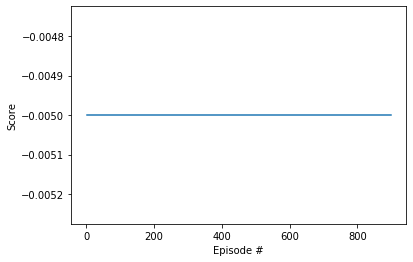

In [19]:
TARGET_REWARD=45

PATTERN_0 = False
PATTERN_1 = False
PATTERN_4 = True

agent = AgentBN(state_size=state_size, action_size=action_size, random_seed=2)

#4. Increase max_t from 300 to 1,000
scores = ddpg(agent, num_agents, n_episodes=4000, max_t=1000, print_every=20, target_reward=TARGET_REWARD)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!
In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = []
        for i in range(len(states)):
            action = agent.act(states[i])
            actions.append(action)

        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
watch_agent(agent)

In [ ]:

env.close()